In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25,detection_method="energy_detection"):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]
        valid_methods = ["energy_detection", "matched_filter", "cyclostationary"]
        if detection_method not in valid_methods:
            raise ValueError(f"Invalid detection method. Choose from {valid_methods}")
        self.detection_method = detection_method
    
    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices

    def _generate_spectrum_state(self):
        """
        Generate a spectrum state using Markov chain dynamics for each band.
        Each band has a distinct transition matrix and evolves over 'steps' timesteps.
        """
        new_states = []

        for band in range(self.num_bands):
            # Get the last state or default to 0 if no history exists
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0

            # Generate states for the next 'steps' timesteps using the Markov chain
            band_states = []
            for _ in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step

            # Append the generated states to history
            self.channel_states[band] = band_states
        return self.channel_states
    
    def energy_detection(self, time_step, band, delta=0.1):
        """
        Perform energy detection for a specific band and timestep.
        Calculates energy dynamically and assigns rewards based on the state and energy detection.

        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).

        Returns:
        - reward (int): The reward calculated based on energy detection and the channel state.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Retrieve previous energy state (default to 0 if no previous energy state)
        previous_energy = self.energy_costs[band][-1] if len(self.energy_costs[band]) > 0  else 0

        # Calculate new energy state
        if current_state == 1:
            # Increase energy by delta if the state is 1
            new_energy = previous_energy + delta
        else:
            # No change in energy if the state is 0
            new_energy = previous_energy

        self.energy_costs[band].append(new_energy)
        return new_energy

    def matched_filter_fft(self,time_step,band):
        """
        Simulates matched filter detection using FFT with adaptive energy consumption.
        Energy consumption is higher for detecting occupied states (state = 1).
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by the matched filter detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]
        # Base energy consumption for matched filter detection
        base_energy = 0.2
        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.1 if current_state == 1 else 0.05

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        if sensing_history_length > 0:
            history_energy = 0.02 + self.energy_costs[band][-1]
        else:
            history_energy = 0.02

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy
        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption


    def cyclostationary_detection(self,time_step,band):
        """
        Simulates cyclostationary feature detection based on periodic properties.
        Energy consumption is moderate and depends on the band state and history.
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by cyclostationary detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for cyclostationary detection
        base_energy = 0.15

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.07 if current_state == 1 else 0.03

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        if sensing_history_length > 0:
            history_energy = 0.015 + self.energy_costs[band][-1]
        else:
            history_energy = 0.015

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption
    
    def detect(self,time_step,band):
        if self.detection_method == "energy_detection":
            return self.energy_detection(time_step, band)
        elif self.detection_method == "matched_filter":
            return self.matched_filter_fft(time_step, band)
        elif self.detection_method == "cyclostationary":
            return self.cyclostationary_detection(time_step, band)
    def step(self, time_step, band):
        """
        Calculate the reward based on the state of a given channel at a specific timestep.
        
        Parameters:
        - time_step (int): The time step to evaluate.
        - band (int): The band (channel) number to evaluate.
        
        Returns:
        - reward (int): The reward gained from the channel's state at the specified time step.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Get the state of the specified channel at the given timestep
        state = self.channel_states[band][time_step]

        # Calculate the reward
        reward = 30 if state == 0 else -15

        # Update the total reward and track the step reward
        self.total_reward += reward
        self.rewards.append(reward)

        return reward
    
    def soft_reset(self):
        self.energy_costs = [[] for _ in range(self.num_bands)]
        

In [72]:
class QLearningAgent:
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        """
        Initialize the Q-learning agent.

        Parameters:
        - environment: The SpectrumEnvironment object.
        - alpha (float): Learning rate.
        - gamma (float): Discount factor.
        - epsilon (float): Exploration probability.
        """
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Q-table: States are (time_step), actions are (2 * num_bands)
        self.q_table = np.zeros((self.env.steps, 2 * self.env.num_bands))

    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy.

        Parameters:
        - state (tuple): The current state (time_step).

        Returns:
        - action (int): The selected action (band and energy detection choice).
        """
        time_step = state[0]
        if np.random.rand() < self.epsilon:
            # Exploration: Randomly select an action
            return np.random.randint(0, 2 * self.env.num_bands)
        else:
            # Exploitation: Select the action with the highest Q-value
            return np.argmax(self.q_table[time_step])

    def update_q_table(self, state, action, reward, next_state):
        """
        Update the Q-value for a given state-action pair.

        Parameters:
        - state (tuple): The current state (time_step).
        - action (int): The chosen action (band and energy detection).
        - reward (float): The reward received.
        - next_state (tuple): The next state (time_step + 1).
        """
        time_step = state[0]
        next_time_step = next_state[0]

        # Get the maximum Q-value for the next state
        max_next_q = np.max(self.q_table[next_time_step])

        # Update the Q-value using the Q-learning formula
        self.q_table[time_step, action] += self.alpha * (
            reward + self.gamma * max_next_q - self.q_table[time_step, action]
        )

    def train(self, episodes):
        """
        Train the agent over multiple episodes.

        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        total_rewards_per_episode = []  # Track total rewards per episode for visualization

        for episode in range(episodes):
            print(f"Episode {episode + 1}/{episodes}")

            # Reset the environment state and energy history
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0

            # Start at the first timestep
            for time_step in range(self.env.steps - 1):
                state = (time_step,)

                # Choose an action (band and energy detection choice)
                action = self.choose_action(state)

                # Determine band and whether to use energy detection
                band = action % self.env.num_bands
                use_energy_detection = action >= self.env.num_bands

                # Calculate energy detection cost (if used)
                energy = self.env.detect(time_step, band) if use_energy_detection else 0

                # Calculate the reward (penalize based on energy)
                raw_reward = self.env.step(time_step, band)
                reward = raw_reward - energy

                # Move to the next state
                next_state = (time_step + 1,)

                # Update Q-table
                self.update_q_table(state, action, reward, next_state)

                # Track the total reward for the episode
                total_reward += reward

            total_rewards_per_episode.append(total_reward)
            print(f"Total Reward for Episode {episode + 1}: {total_reward}")

        # Plot learning progress
        plt.plot(total_rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Progress")
        plt.show()



energy_detection


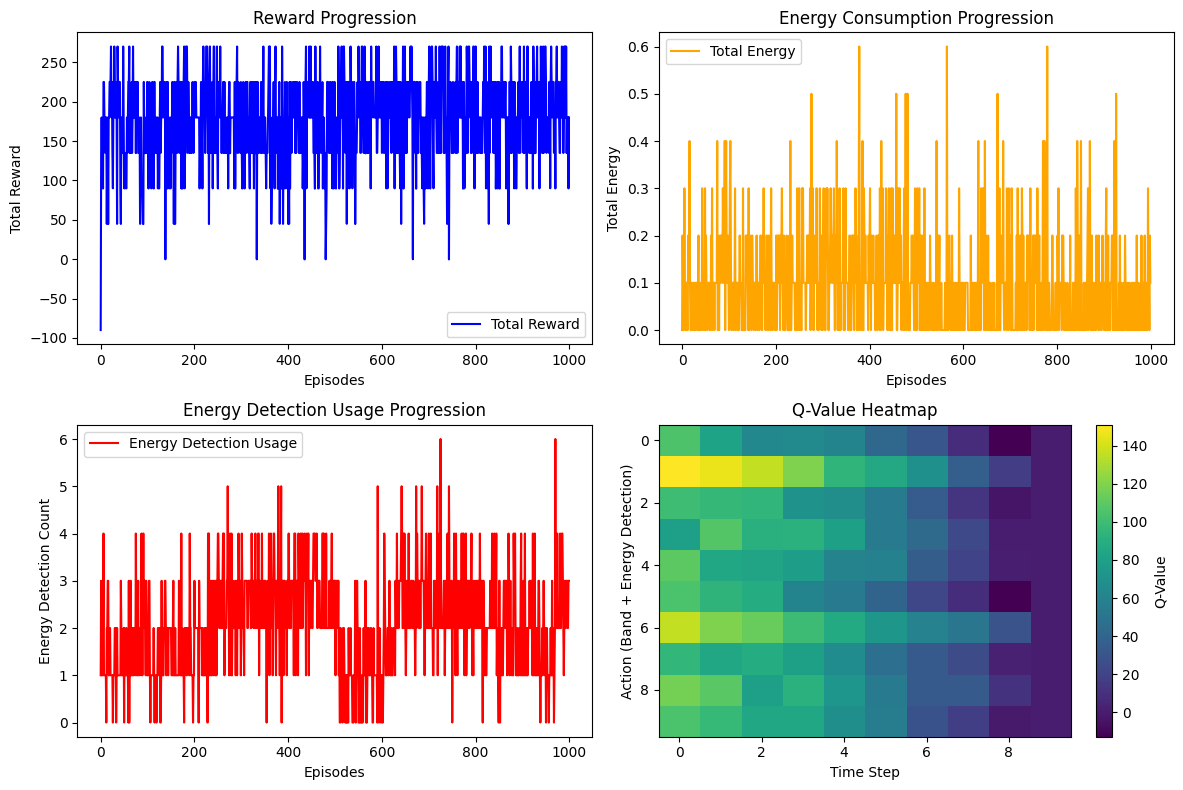

matched_filter


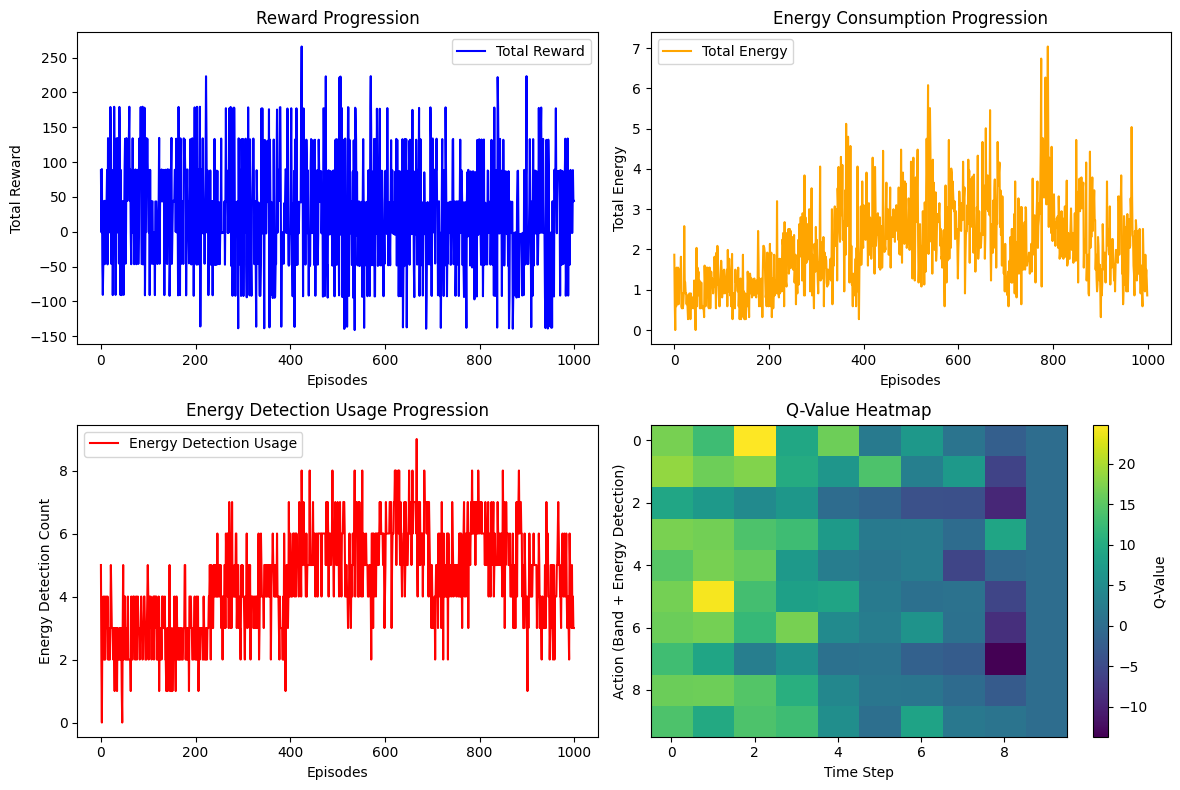

cyclostationary


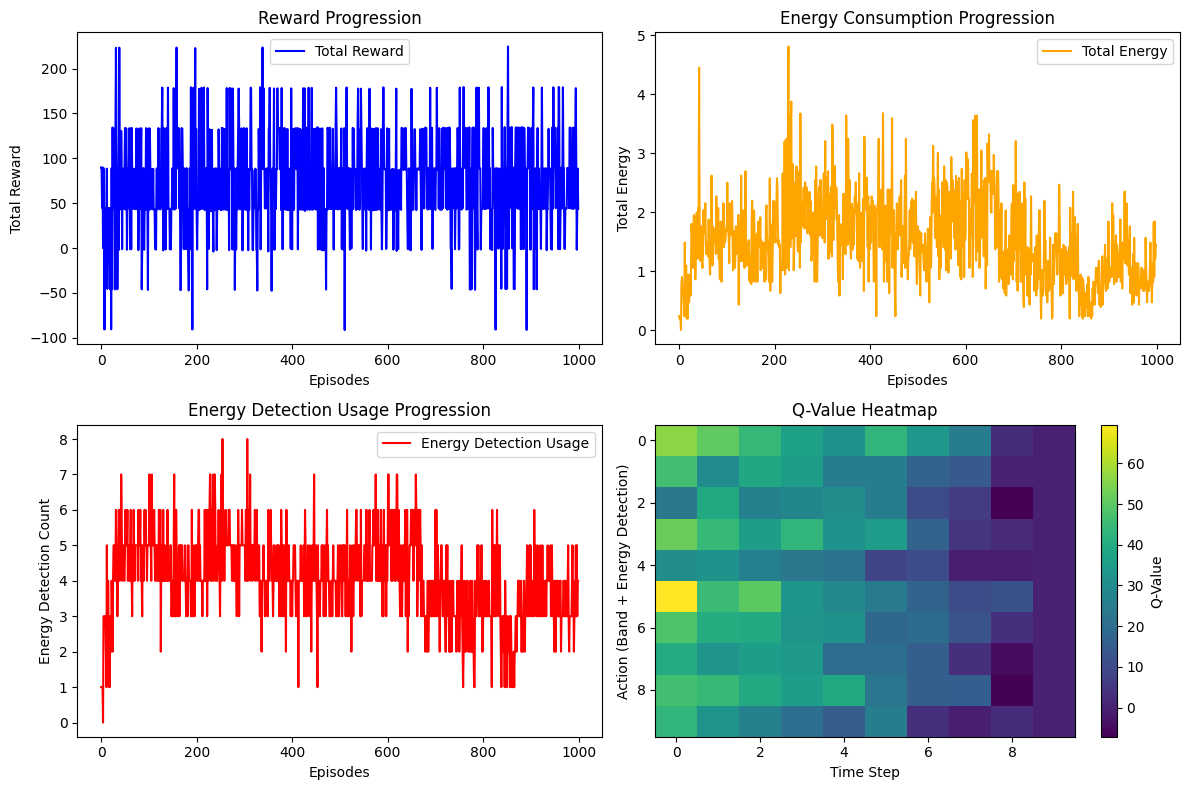

In [73]:
class QLearningAgentWithVisualization(QLearningAgent):
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(environment, alpha, gamma, epsilon)
        self.episode_rewards = []  # Track total rewards per episode
        self.episode_energy = []  # Track total energy consumption per episode
        self.action_counts = np.zeros(2 * self.env.num_bands)  # Track action selection frequency
        self.energy_detection_usage = []  # Track how often energy detection is used per episode

    def train(self, episodes):
        """
        Train the agent over multiple episodes with visualization tracking.
        
        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        for episode in range(episodes):
            # Reset environment for each episode
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0
            total_energy = 0
            energy_detection_count = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)
                # Choose an action (band + energy detection choice)
                action = self.choose_action(state)
                self.action_counts[action] += 1  # Track action frequency

                # Determine band and whether to use energy detection
                band = action % self.env.num_bands
                use_energy_detection = action >= self.env.num_bands

                # Calculate energy dynamically (decided by Q-learning)
                energy = self.env.detect(time_step, band) if use_energy_detection else 0
                if use_energy_detection:
                    energy_detection_count += 1
                total_energy += energy

                # Calculate the reward (penalize based on energy)
                raw_reward = self.env.step(time_step, band)
                reward = raw_reward - energy

                # Move to the next state
                next_state = (time_step + 1,)

                # Update Q-table
                self.update_q_table(state, action, reward, next_state)
                # Track the total reward
                total_reward += reward

            # Store metrics for visualization
            self.episode_rewards.append(total_reward)
            self.episode_energy.append(total_energy)
            self.energy_detection_usage.append(energy_detection_count)

    def visualize_results(self):
        """
        Visualize the results of training using matplotlib.
        """
        episodes = len(self.episode_rewards)

        # Plot Total Rewards per Episode
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()

        # Plot Total Energy per Episode
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Total Energy", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Total Energy")
        plt.title("Energy Consumption Progression")
        plt.legend()

        # Plot Energy Detection Usage per Episode
        plt.subplot(2, 2, 3)
        plt.plot(range(episodes), self.energy_detection_usage, label="Energy Detection Usage", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Energy Detection Count")
        plt.title("Energy Detection Usage Progression")
        plt.legend()

        # Visualize Q-Value Evolution (Heatmap)
        plt.subplot(2, 2, 4)
        plt.imshow(self.q_table.T, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Action (Band + Energy Detection)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()

for i in ["energy_detection", "matched_filter", "cyclostationary"]:
    print(i)
    env = SpectrumEnvironment(num_bands=5, steps=10,detection_method=i)
    agent = QLearningAgentWithVisualization(env, alpha=0.1, gamma=0.9, epsilon=0.2)
    agent.train(episodes=1000)
    agent.visualize_results()